# Step1:Take a random 70% samples for training and the rest 30% for test.

In [2]:
import pandas as pd
titanic = pd.read_csv('Titanic.csv',header = 0)

X = titanic[['pclass','sex','age','sibsp']]
y = titanic['survived']
print(X.head())
print(y.head())

  pclass     sex      age  sibsp
0    1st  female  29.0000      0
1    1st    male   0.9167      1
2    1st  female   2.0000      1
3    1st    male  30.0000      1
4    1st  female  25.0000      1
0    1
1    1
2    0
3    0
4    0
Name: survived, dtype: int64


In [3]:
#processing
age = X['age'].fillna(value = X['age'].mean()).astype('int')
pclass = pd.get_dummies(X['pclass'], prefix='pclass')
sex = (X['sex']=='male').astype('int')
sibsp = X['sibsp']
X = pd.concat([pclass, age ,sex,sibsp],axis=1)
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 6 columns):
pclass_1st    1309 non-null uint8
pclass_2nd    1309 non-null uint8
pclass_3rd    1309 non-null uint8
age           1309 non-null int32
sex           1309 non-null int32
sibsp         1309 non-null int64
dtypes: int32(2), int64(1), uint8(3)
memory usage: 24.4 KB
None


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 33)
vec = DictVectorizer(sparse = False)
X_train = vec.fit_transform(X_train.to_dict(orient='record'))
X_test = vec.fit_transform(X_test.to_dict(orient='record'))
feature_names = vec.feature_names_

print(feature_names)

['age', 'pclass_1st', 'pclass_2nd', 'pclass_3rd', 'sex', 'sibsp']


# Step2:Plot the full tree.

In [6]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
print("accuracy:{:.2f}".format(clf.score(X_test,y_test)))
print("clf:" + str(clf))

accuracy:0.81
clf:DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


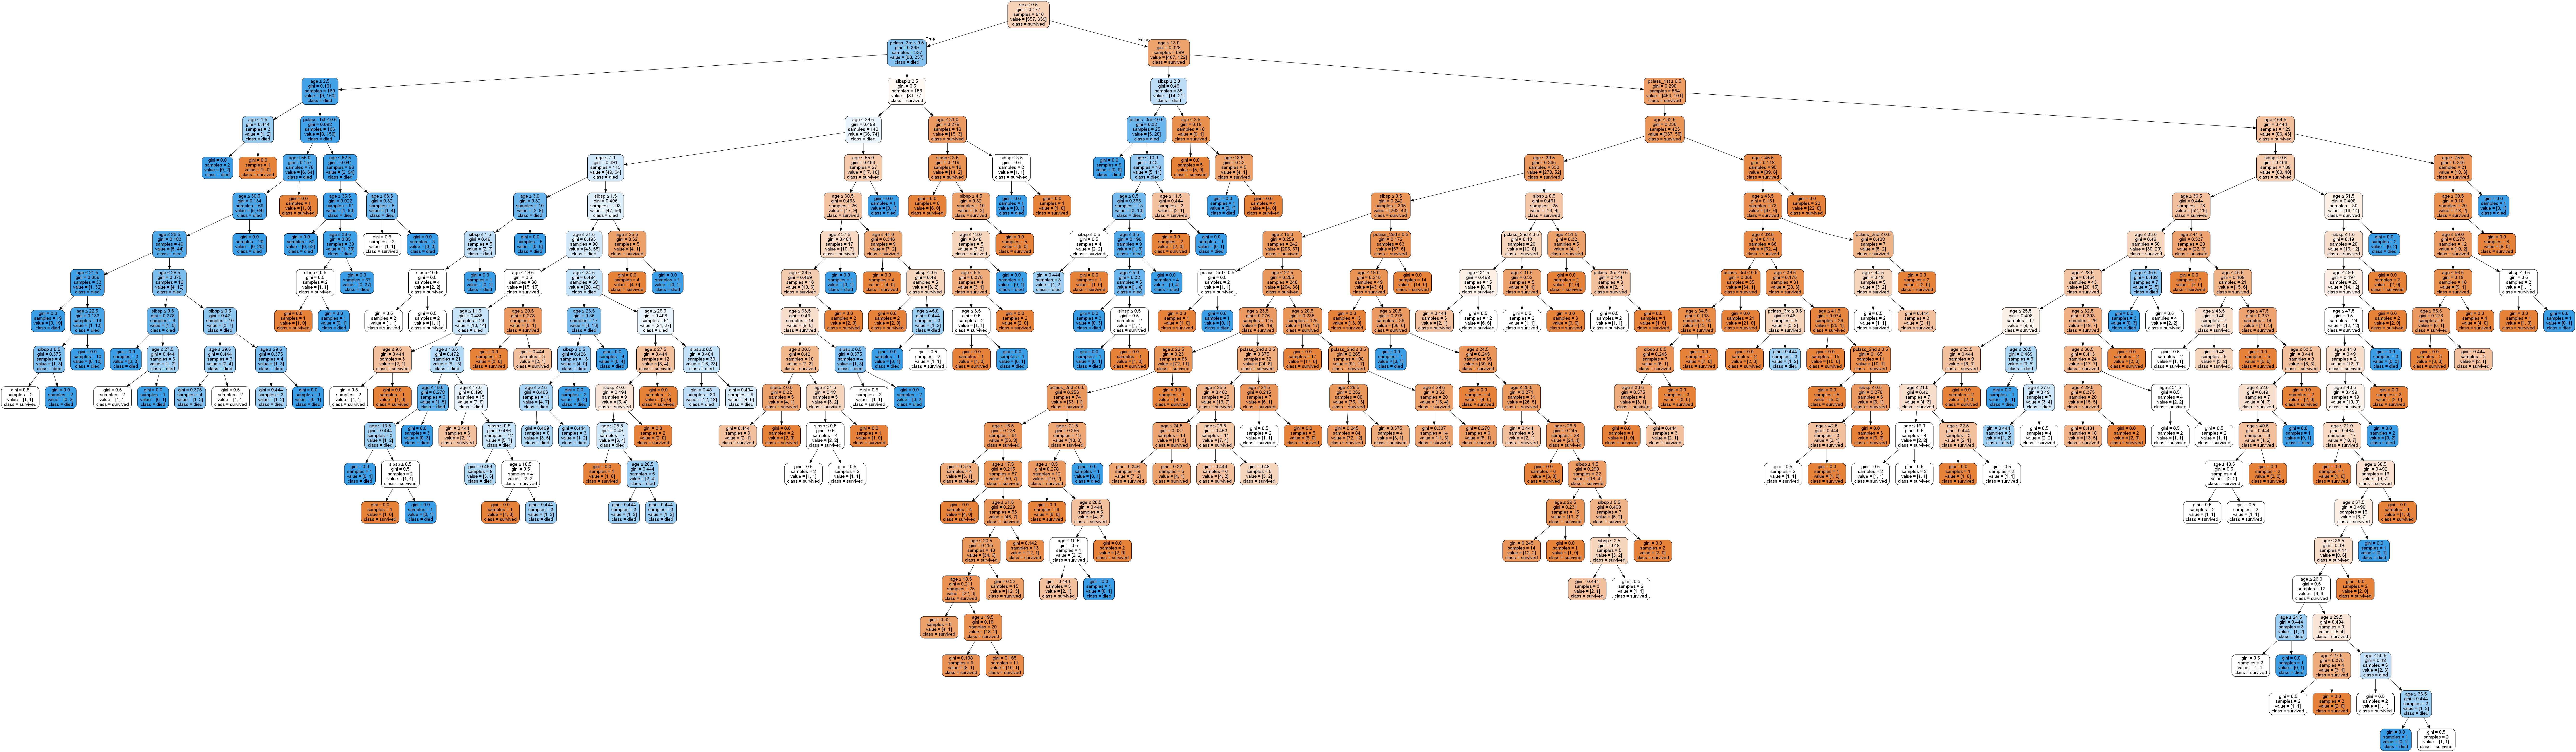

In [22]:
from IPython.display import Image
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/MyDrivers/Graphviz2.38/bin/'
target_names = ['survived','died']
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=vec.feature_names_,
                         class_names=target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# save as .pdf
graph.write_pdf("titanic_fulltree.pdf")
Image(graph.create_png())  

# Step3:check the performance of the full model: in‐sample and out-of‐sample accuracy

In [9]:
#use cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile,chi2
import numpy as np
percentiles = range(1,100)
results = []
for i in percentiles:
    fs = SelectPercentile(chi2,percentile=i)
    X_train_fs = fs.fit_transform(X_train,y_train)
    scores = cross_val_score(clf, X_train_fs,y_train,cv=10)
    results = np.append(results,scores.mean())

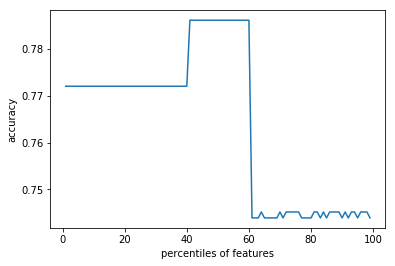

In [10]:
import matplotlib.pyplot as plt
plt.plot(percentiles,results)
plt.xlabel('percentiles of features')
plt.ylabel('accuracy')
plt.show()

In [8]:
y_predict_test = clf.predict(X_test)
y_predict_train= clf.predict(X_train)
from sklearn.metrics import accuracy_score

print("Step3:")
print ("accuracy in sample(training set) : "+str(accuracy_score(y_train, y_predict_train)))
print ("accuracy out of sample (test set) : "+str(accuracy_score(y_test, y_predict_test)))
print("\n")
from sklearn.metrics import confusion_matrix
#confusion matrix
print("Training set:")
a=confusion_matrix(y_train, y_predict_train)
print("Percent of survivors correctly predicted(on training set):")
print(a[1][1]/(a[1][1]+a[1][0]))
print("Percent of fatalities correctly predicted(on training set):")
print(a[0][0]/(a[0][1]+a[0][0]))
print("\n")
print("Test set:")
b=confusion_matrix(y_test, y_predict_test)
print("Percent of survivors correctly predicted(on test set):")
print(b[1][1]/(b[1][1]+b[1][0]))
print("Percent of fatalities correctly predicted(on test set):")
print(b[0][0]/(b[0][1]+b[0][0]))




Step3:
accuracy in sample(training set) : 0.867903930131
accuracy out of sample (test set) : 0.809160305344


Training set:
Percent of survivors correctly predicted(on training set):
0.74930362117
Percent of fatalities correctly predicted(on training set):
0.94434470377


Test set:
Percent of survivors correctly predicted(on test set):
0.702127659574
Percent of fatalities correctly predicted(on test set):
0.869047619048


# Step4:Find the minimum number of misclassification and choose the corresponding tree size to prune the tree.

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
tree_size = range(2,10)
misclf = []
for i in tree_size:
    param = {'criterion':['gini','entropy'],
             "min_samples_split":range(2,4,8),
             "max_depth":[None,2,4,8],
             "min_samples_leaf":[3,5,8],
             "max_leaf_nodes": [i]}
    grid_search = GridSearchCV(clf,param,cv=10)
    grid_search.fit(X_test,y_test)
    y_predict_test = grid_search.predict(X_test)
    a = confusion_matrix(y_test, y_predict_test)
    misclf.append(a[0][1]+a[1][0])
#cv_result = pd.DataFrame.from_dict(grid_search.cv_results_)
# with open('cv_results.csv','w') as f:
#     cv_result.to_csv(f)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_leaf_nodes': 9, 'min_samples_split': 2, 'min_samples_leaf': 3, 'criterion': 'gini', 'max_depth': 2}
0.809160305344


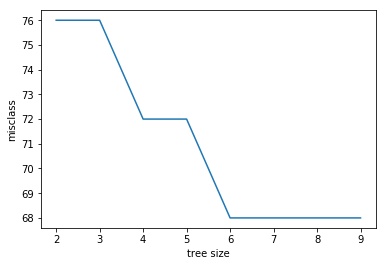

In [15]:
import matplotlib.pyplot as plt
plt.plot(tree_size,misclf)
plt.xlabel('tree size')
plt.ylabel('misclass')
plt.show()

# Stpe5:Prune the tree with the optimal tree size. Plot the pruned tree.

In [13]:
# best tree
best_tree=tree.DecisionTreeClassifier(criterion='gini',max_leaf_nodes=6)
best_tree=best_tree.fit(X_train,y_train)
print("accuracy:{:.2f}".format(best_tree.score(X_test,y_test)))

accuracy:0.82


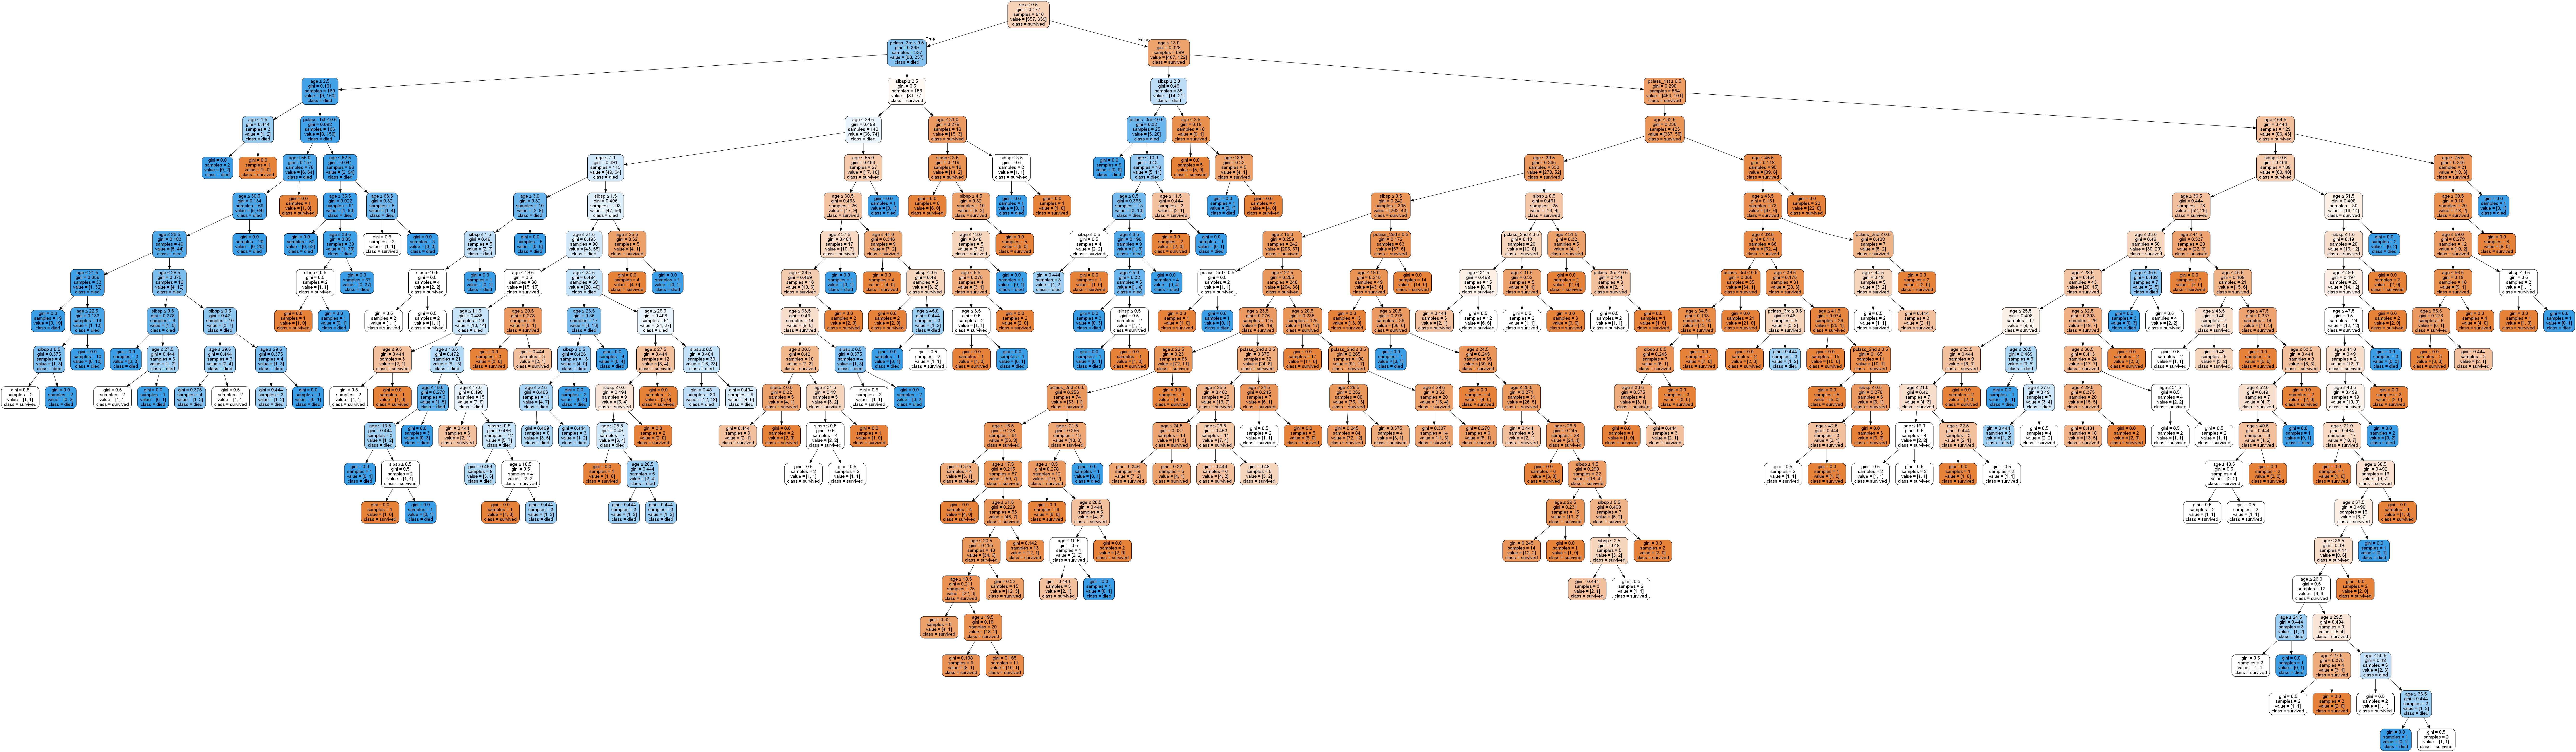

In [21]:
from IPython.display import Image
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/MyDrivers/Graphviz2.38/bin/'
target_names = ['survived','died']
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=vec.feature_names_,
                         class_names=target_names,
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
# save as .pdf
graph.write_pdf("titanic_besttree.pdf")
Image(graph.create_png())  

# Step6:Report as many details as you can on the final pruned tree.

In [18]:
y_predict_test = best_tree.predict(X_test)
y_predict_train= best_tree.predict(X_train)
print("Step6:")
print ("accuracy in sample(training set) : "+str(accuracy_score(y_train, y_predict_train)))
print ("accuracy out of sample (test set) : "+str(accuracy_score(y_test, y_predict_test)))
print("\n")
from sklearn.metrics import confusion_matrix
#confusion matrix
print("Training set:")
a=confusion_matrix(y_train, y_predict_train)
print("Percent of survivors correctly predicted(on training set):")
print(a[1][1]/(a[1][1]+a[1][0]))
print("Percent of fatalities correctly predicted(on training set):")
print(a[0][0]/(a[0][1]+a[0][0]))
print("\n")
print("Test set:")
b=confusion_matrix(y_test, y_predict_test)
print("Percent of survivors correctly predicted(on test set):")
print(b[1][1]/(b[1][1]+b[1][0]))
print("Percent of fatalities correctly predicted(on test set):")
print(b[0][0]/(b[0][1]+b[0][0]))

Step6:
accuracy in sample(training set) : 0.789301310044
accuracy out of sample (test set) : 0.821882951654


Training set:
Percent of survivors correctly predicted(on training set):
0.50139275766
Percent of fatalities correctly predicted(on training set):
0.97486535009


Test set:
Percent of survivors correctly predicted(on test set):
0.567375886525
Percent of fatalities correctly predicted(on test set):
0.964285714286


After pruned the tree the accuracy in sample(training set) : 78.93% accuracy out of sample (test set) : 82.19%

By comparing the previous the accuracy accuracy in sample(training set) : 86.79% accuracy out of sample (test set) : 80.92%

The accuracy out of sample (test set) is worse after pruned the tree(80.92%<82.19%).

By using the DecisionTreeClassifier() function, the max_leaf_nodes should be 6 to prune the tree. Because the accuracy out of sample for prune is 82.19%, the highest number.

After pruned the tree the : Percent of survivors correctly predicted(on training set): 50.13% Percent of fatalities correctly predicted(on training set):97.48% Percent of survivors correctly predicted(on test set):56.74% Percent of fatalities correctly predicted(on test set):96.43%

There is indead an improvement in out of sample for the full tree and the pruned tree.